# KNN

1．$k$近邻法是基本且简单的分类与回归方法。$k$近邻法的基本做法是：对给定的训练实例点和输入实例点，首先确定输入实例点的$k$个最近邻训练实例点，然后利用这$k$个训练实例点的类的多数来预测输入实例点的类。

2．$k$近邻模型对应于基于训练数据集对特征空间的一个划分。$k$近邻法中，当训练集、距离度量、$k$值及分类决策规则确定后，其结果唯一确定。

3．$k$近邻法三要素：`距离度量`、`K值的选择`和`分类决策规则`:
   - 常用的距离度量是欧氏距离及更一般的**pL**距离.
   - $k$值小时，$k$近邻模型更复杂；$k$值大时，$k$近邻模型更简单。$k$值的选择反映了对近似误差与估计误差之间的权衡，通常由交叉验证选择最优的$k$。
   - 常用的分类决策规则是多数表决，对应于经验风险最小化。

4．$k$近邻法的实现需要考虑如何快速搜索k个最近邻点。**kd**树是一种便于对k维空间中的数据进行快速检索的数据结构。kd树是二叉树，表示对$k$维空间的一个划分，其每个结点对应于$k$维空间划分中的一个超矩形区域。利用**kd**树可以省去对大部分数据点的搜索， 从而减少搜索的计算量。

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
%matplotlib inline

## 距离度量

设特征空间$x$是$n$维实数向量空间 ，$x_{i}, x_{j} \in \mathcal{X}$,$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(n)}\right)^{\mathrm{T}}$,$x_{j}=\left(x_{j}^{(1)}, x_{j}^{(2)}, \cdots, x_{j}^{(n)}\right)^{\mathrm{T}}$
，则：$x_i$,$x_j$的$L_p$距离定义为:


$L_{p}\left(x_{i}, x_{j}\right)=\left(\sum_{i=1}^{n}\left|x_{i}^{(i)}-x_{j}^{(l)}\right|^{p}\right)^{\frac{1}{p}}$

- $p= 1$  曼哈顿距离
- $p= 2$  欧氏距离
- $p= inf$  闵式距离minkowski_distance 

In [3]:
def L(x, y, p=2):
    x = np.array(x)
    y = np.array(y)
    return np.power(np.power(np.abs(x-y), p).sum(), 1/p)

In [4]:
x1 = [1,1]
x2 = [5,1]
x3 = [4,4]
{f"1 - {c} - p = {i}": L(x1, c, p=i) for i in range(1, 5) for c in [x2, x3]}

{'1 - [5, 1] - p = 1': 4.0,
 '1 - [4, 4] - p = 1': 6.0,
 '1 - [5, 1] - p = 2': 4.0,
 '1 - [4, 4] - p = 2': 4.242640687119285,
 '1 - [5, 1] - p = 3': 3.9999999999999996,
 '1 - [4, 4] - p = 3': 3.7797631496846193,
 '1 - [5, 1] - p = 4': 4.0,
 '1 - [4, 4] - p = 4': 3.5676213450081633}

In [5]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.tail(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
140,6.7,3.1,5.6,2.4,2
141,6.9,3.1,5.1,2.3,2
142,5.8,2.7,5.1,1.9,2
143,6.8,3.2,5.9,2.3,2
144,6.7,3.3,5.7,2.5,2
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


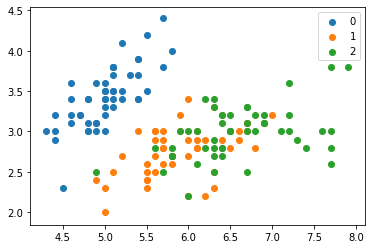

In [90]:
plt.scatter(df.iloc[:50,0], df.iloc[:50, 1], label='0')
plt.scatter(df.iloc[50:100,0], df.iloc[50:100, 1], label='1')
plt.scatter(df.iloc[100:150,0], df.iloc[100:150, 1], label='2')
plt.legend()
plt.show()

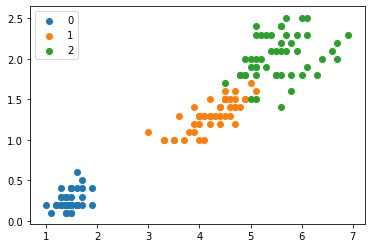

In [97]:
plt.scatter(df.iloc[:50,2], df.iloc[:50,3], label='0')
plt.scatter(df.iloc[50:100,2], df.iloc[50:100, 3], label='1')
plt.scatter(df.iloc[100:150,2], df.iloc[100:150, 3], label='2')
plt.legend()
plt.show()

In [71]:
data = np.array(df.iloc[:100, [0,1,-1]])
X, y = data[:, :-1], data[:, -1]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((80, 2), (20, 2), (80,), (20,))

## 手动实现

In [75]:
class KNN:
    def __init__(self, Xtrain ,ytrain , nn=3):
        self.n = nn
        self.Xtrain = Xtrain
        self.ytrain = ytrain
    
    def predict(self, X):
        initial_nn = [(np.linalg.norm(X - Xtrain[i]), ytrain[i]) for i in range(len(self.Xtrain))]
        sorted_ = sorted(initial_nn, key=lambda x: x[0])
        prediction = Counter(k[1] for k in sorted_[:self.n]).most_common()[0][0]
        return prediction
    
    def score(self, Xtest, ytest):
        ypred = [self.predict(x) for x in Xtest]
        result = np.mean(ypred==ytest)
        return round(result, 3)

In [76]:
clf = KNN(Xtrain, ytrain)

In [77]:
clf.score(Xtest,ytest)

0.95

In [94]:
test_dot = [6., 3.]
clf.predict(test_dot)

1.0

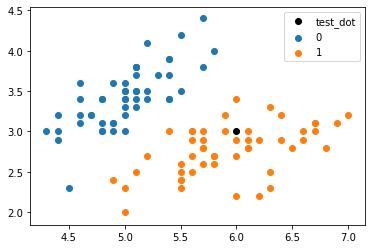

In [95]:
plt.scatter(df.iloc[:50,0], df.iloc[:50, 1], label='0')
plt.scatter(df.iloc[50:100,0], df.iloc[50:100, 1], label='1')
plt.plot(test_dot[0], test_dot[1], 'ko', label='test_dot')
plt.legend()
plt.show()

## sklearn内置类实现

In [105]:
data = np.array(df.iloc[:, [0,1,-1]])
X, y = data[:, :-1], data[:, -1]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((120, 2), (30, 2), (120,), (30,))

In [111]:
clf = KNC(n_neighbors=7)
clf.fit(Xtrain, ytrain)
clf.score(Xtest, ytest)

0.8333333333333334

In [112]:
ypred = clf.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       0.82      0.75      0.78        12
         2.0       0.57      0.67      0.62         6

    accuracy                           0.83        30
   macro avg       0.80      0.81      0.80        30
weighted avg       0.84      0.83      0.84        30



In [113]:
candidates = range(1,9)

In [114]:
parameters = {"n_neighbors": candidates}
knc = KNC()
clf = GridSearchCV(knc, parameters, n_jobs=-1, cv=5)
clf.fit(Xtrain, ytrain)

C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid={'n_neighbors': range(1, 9)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [110]:
clf.best_params_

{'n_neighbors': 7}

In [115]:
clf.best_score_

0.8

In [117]:
clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [118]:
clf.best_index_

6

## KD树

**kd**树是一种对k维空间中的实例点进行存储以便对其进行快速检索的树形数据结构。

**kd**树是二叉树，表示对$k$维空间的一个划分（partition）。构造**kd**树相当于不断地用垂直于坐标轴的超平面将$k$维空间切分，构成一系列的k维超矩形区域。kd树的每个结点对应于一个$k$维超矩形区域。

构造**kd**树的方法如下：

构造根结点，使根结点对应于$k$维空间中包含所有实例点的超矩形区域；通过下面的递归方法，不断地对$k$维空间进行切分，生成子结点。在超矩形区域（结点）上选择一个坐标轴和在此坐标轴上的一个切分点，确定一个超平面，这个超平面通过选定的切分点并垂直于选定的坐标轴，将当前超矩形区域切分为左右两个子区域
（子结点）；这时，实例被分到两个子区域。这个过程直到子区域内没有实例时终止（终止时的结点为叶结点）。在此过程中，将实例保存在相应的结点上。

通常，依次选择坐标轴对空间切分，选择训练实例点在选定坐标轴上的中位数
（median）为切分点，这样得到的**kd**树是平衡的。注意，平衡的**kd**树搜索时的效率未必是最优的。


### 构造平衡kd树算法
输入：$k$维空间数据集$T＝\{x_1，x_2,…,x_N\}$，

其中$x_{i}=\left(x_{i}^{(1)}, x_{i}^{(2)}, \cdots, x_{i}^{(k)}\right)^{\mathrm{T}}$ ，$i＝1,2,…,N$；

输出：**kd**树。

（1）开始：构造根结点，根结点对应于包含$T$的$k$维空间的超矩形区域。

选择$x^{(1)}$为坐标轴，以T中所有实例的$x^{(1)}$坐标的中位数为切分点，将根结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

由根结点生成深度为1的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域， 右子结点对应于坐标$x^{(1)}$大于切分点的子区域。

将落在切分超平面上的实例点保存在根结点。

（2）重复：对深度为$j$的结点，选择$x^{(1)}$为切分的坐标轴，$l＝j(modk)+1$，以该结点的区域中所有实例的$x^{(1)}$坐标的中位数为切分点，将该结点对应的超矩形区域切分为两个子区域。切分由通过切分点并与坐标轴$x^{(1)}$垂直的超平面实现。

由该结点生成深度为$j+1$的左、右子结点：左子结点对应坐标$x^{(1)}$小于切分点的子区域，右子结点对应坐标$x^{(1)}$大于切分点的子区域。

将落在切分超平面上的实例点保存在该结点。

（3）直到两个子区域没有实例存在时停止。从而形成**kd**树的区域划分。